In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
print(tf.__version__)

2.5.0


# Loading the dataset

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/Major Project/New DF.csv")

In [ ]:
df['isFake']=df['isFake'].apply(lambda x: str(x))

In [ ]:
df['isFake'].unique()

array(['0', '1'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              x_col='path',
                                              y_col='isFake',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(217,217)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              x_col='path',
                                              y_col='isFake',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              target_size=(217,217)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  x_col='path',
                                                  y_col='isFake',
                                                  class_mode='categorical',
                                                  batch_size=32,
                                                  shuffle=False,
                                                  target_size=(217,217)
                                                 )

Found 3159 validated image filenames belonging to 2 classes.
Found 351 validated image filenames belonging to 2 classes.
Found 878 validated image filenames belonging to 2 classes.


# Model Building

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=((217,217,3))))
clf_model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 217, 217, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 223, 223, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 109, 109, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 109, 109, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for layer in clf_model.layers:
    layer.trainable = False

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(217, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(217, activation='relu')(head)
head = Dropout(0.3)(head)

head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 217, 217, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 223, 223, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 109, 109, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 109, 109, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

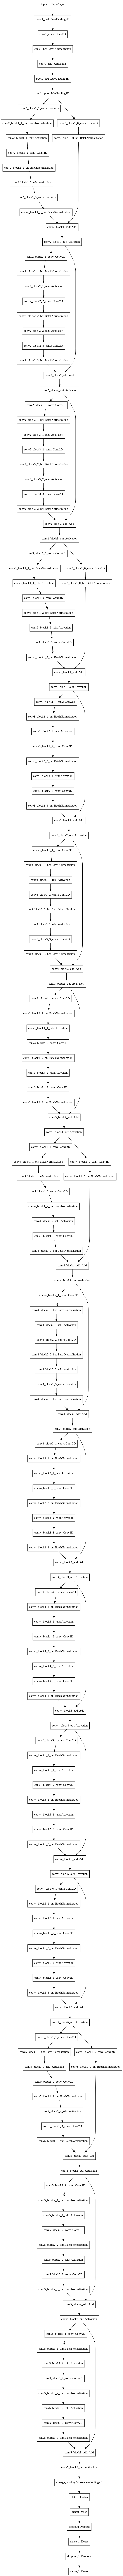

In [ ]:
plot_model(model)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=5
                             )
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/Major Project/Sample_clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
callbacks = [checkpointer, earlystopping]

# Model Training

In [ ]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 20, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])

Epoch 1/20
98/98 [==============================] - 1173s 12s/step - loss: 0.4255 - accuracy: 0.8091 - val_loss: 0.3692 - val_accuracy: 0.8625

Epoch 00001: val_loss improved from inf to 0.36925, saving model to /content/drive/MyDrive/Major Project/Sample_clf-resnet-weights.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
98/98 [==============================] - 14s 141ms/step - loss: 0.3083 - accuracy: 0.8855 - val_loss: 0.3189 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.36925 to 0.31889, saving model to /content/drive/MyDrive/Major Project/Sample_clf-resnet-weights.hdf5
Epoch 3/20
98/98 [==============================] - 14s 140ms/step - loss: 0.3133 - accuracy: 0.8791 - val_loss: 0.3281 - val_accuracy: 0.8719

Epoch 00003: val_loss did not improve from 0.31889
Epoch 4/20
98/98 [==============================] - 13s 134ms/step - loss: 0.2973 - accuracy: 0.8913 - val_loss: 0.3104 - val_accuracy: 0.8844

Epoch 00004: val_loss improved from 0.31889 to 0.31041, saving model to /content/drive/MyDrive/Major Project/Sample_clf-resnet-weights.hdf5
Epoch 5/20
98/98 [==============================] - 13s 133ms/step - loss: 0.2819 - accuracy: 0.8909 - val_loss: 0.3026 - val_accuracy: 0.8844

Epoch 00005: val_loss improved from 0.31041 to 0.30255, saving model to /content/drive/MyDriv

In [ ]:
# saving model achitecture in json file
model_json = model.to_json()
with open("/content/drive/MyDrive/Major Project/Sample_clf-resnet-model.json", "w") as json_file:
    json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Results

In [ ]:
h.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

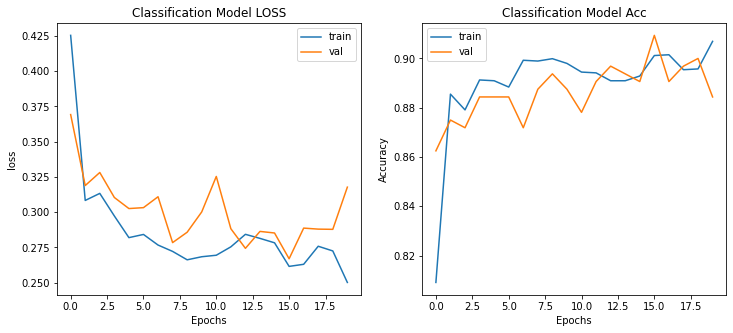

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("Classification Model LOSS");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("Classification Model Acc");
plt.ylabel("Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
_, acc = model.evaluate(test_generator)
print("Test accuracy : {} %".format(acc*100))

28/28 [==============================] - 288s 11s/step - loss: 0.3215 - accuracy: 0.8770
Test accuracy : 87.6993179321289 %


0.876993166287016
              precision    recall  f1-score   support

     Orginal       1.00      0.77      0.87       468
        Fake       0.79      1.00      0.88       410

    accuracy                           0.88       878
   macro avg       0.90      0.88      0.88       878
weighted avg       0.90      0.88      0.88       878



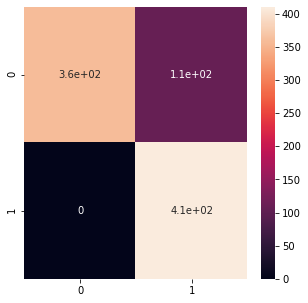

In [ ]:
prediction = model.predict(test_generator)

pred = np.argmax(prediction, axis=1)
#pred = np.asarray(pred).astype('str')
original = np.asarray(test['isFake']).astype('int')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
accuracy = accuracy_score(original, pred)
print(accuracy)

cm = confusion_matrix(original, pred)

report = classification_report(original, pred, labels = [0,1],target_names = ['Orginal', 'Fake'])
print(report)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True);

In [ ]:
from skimage import io
img1=io.imread("/content/drive/MyDrive/Major Project/Sample/Fake/212.png")
img1=img1.reshape((1,217,217,3))

In [ ]:
img2=io.imread("/content/drive/MyDrive/Major Project/Sample/Orginal/302.jpg")
img2=img2.reshape((1,217,217,3))

[[1.0000000e+00 3.2304162e-38]]


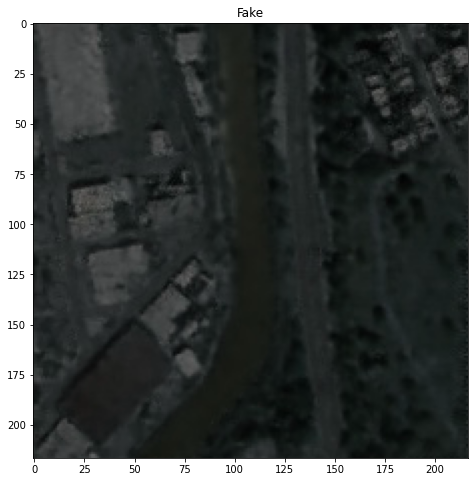

In [ ]:
t1=model.predict(img1)
print(t1)
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread("/content/drive/MyDrive/Major Project/Sample/Fake/312.png"));
plt.title('Fake')
plt.show()


[[1. 0.]]


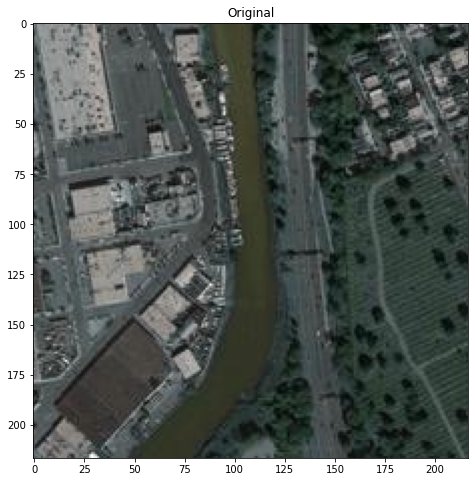

In [ ]:
t2 =model.predict(img2)
print(t2)
plt.figure(figsize=(8,8))
plt.imshow(cv2.imread("/content/drive/MyDrive/Major Project/Sample/Orginal/312.jpg"));
plt.title('Original')
plt.show()